### BRAUX-GUILLIN Valentin, PILCER Michael <br/> École Polytechnique, January 2022

# MAP553 - Forest Cover Type Prediction

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import sklearn as sk
import os

for dirname, _, filenames in os.walk("kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/.DS_Store
kaggle/input/map553-2021/test-full.csv
kaggle/input/map553-2021/full_submission.csv
kaggle/input/map553-2021/train.csv
kaggle/input/map553-2021/test-kag.csv


# 1. Data Exploration

We start by importing data and giving a first look at its shape.

In [2]:
train = pd.read_csv("kaggle/input/map553-2021/train.csv")
test = pd.read_csv("kaggle/input/map553-2021/test-full.csv")
fullsub = pd.read_csv("kaggle/input/map553-2021/full_submission.csv")

In [3]:
print(f"train:   {len(train)}  rows, {len(train.columns)} columns")
print(f"test:    {len(test)} rows, {len(test.columns)} columns")
print(f"fullsub: {len(fullsub)} rows, {len(fullsub.columns)} columns")

train.head()

train:   15120  rows, 56 columns
test:    581012 rows, 55 columns
fullsub: 581012 rows, 2 columns


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,0,0,0,0,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,0,0,0,0,0,0,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1


With ```train.info()``` and ```test.info()```, we check that there are no null values to worry about.<br/>
We add an ```Area```column which will be useful.

In [4]:
train.loc[train["Wilderness_Area1"] == 1, "Area"] = 1
train.loc[train["Wilderness_Area2"] == 1, "Area"] = 2
train.loc[train["Wilderness_Area3"] == 1, "Area"] = 3
train.loc[train["Wilderness_Area4"] == 1, "Area"] = 4

test.loc[test["Wilderness_Area1"] == 1, "Area"] = 1
test.loc[test["Wilderness_Area2"] == 1, "Area"] = 2
test.loc[test["Wilderness_Area3"] == 1, "Area"] = 3

We use histograms to get a better understanding of data.<br/>
We let soil types out for now.

In [5]:
train_viz = train.drop(list(train.filter(regex = 'Wilderness_Area')), axis = 1)
train_viz = train_viz.drop(list(train.filter(regex = 'Soil_Type')), axis = 1)
train_viz.drop("Id", axis = 1, inplace = True)

test_viz = test.drop(list(test.filter(regex = 'Wilderness_Area')), axis = 1)
test_viz = test_viz.drop(list(test.filter(regex = 'Soil_Type')), axis = 1)
test_viz.drop("Id", axis = 1, inplace = True)

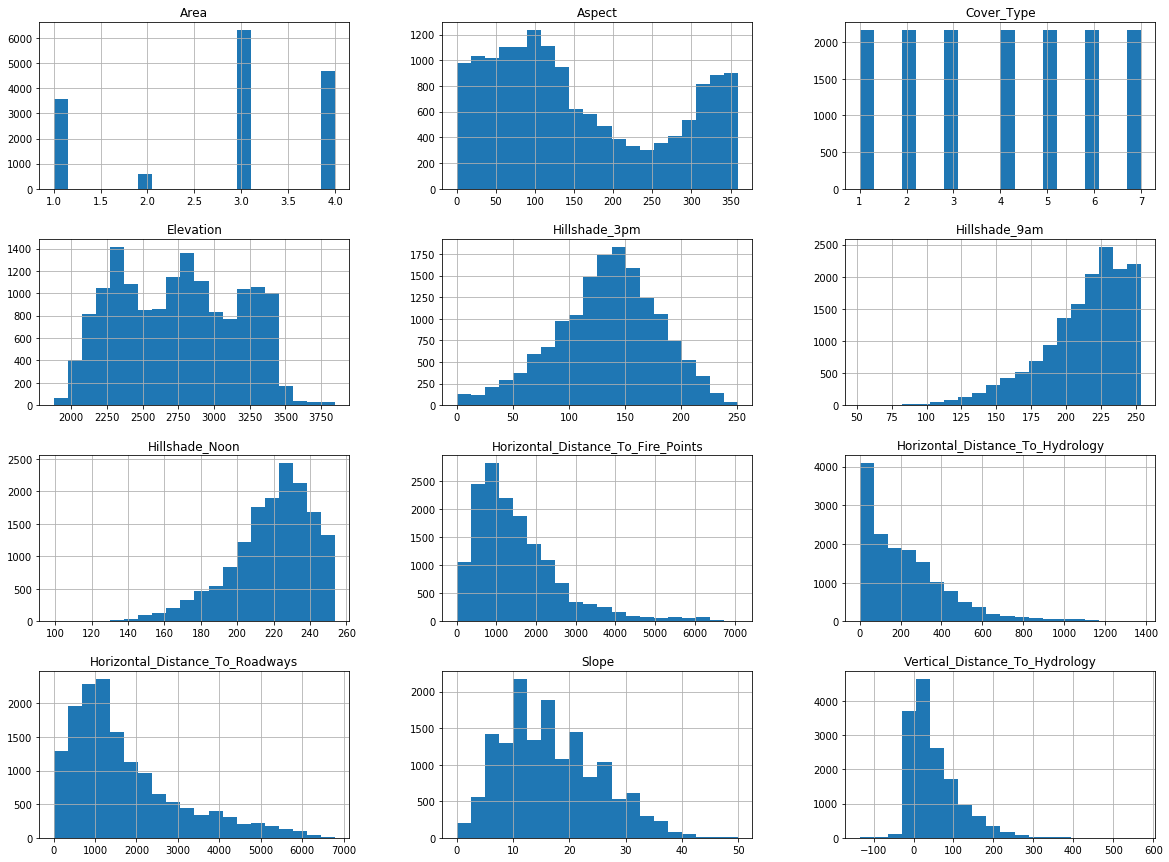

In [6]:
train_viz.hist(bins=20, figsize=(20,15))
plt.show()

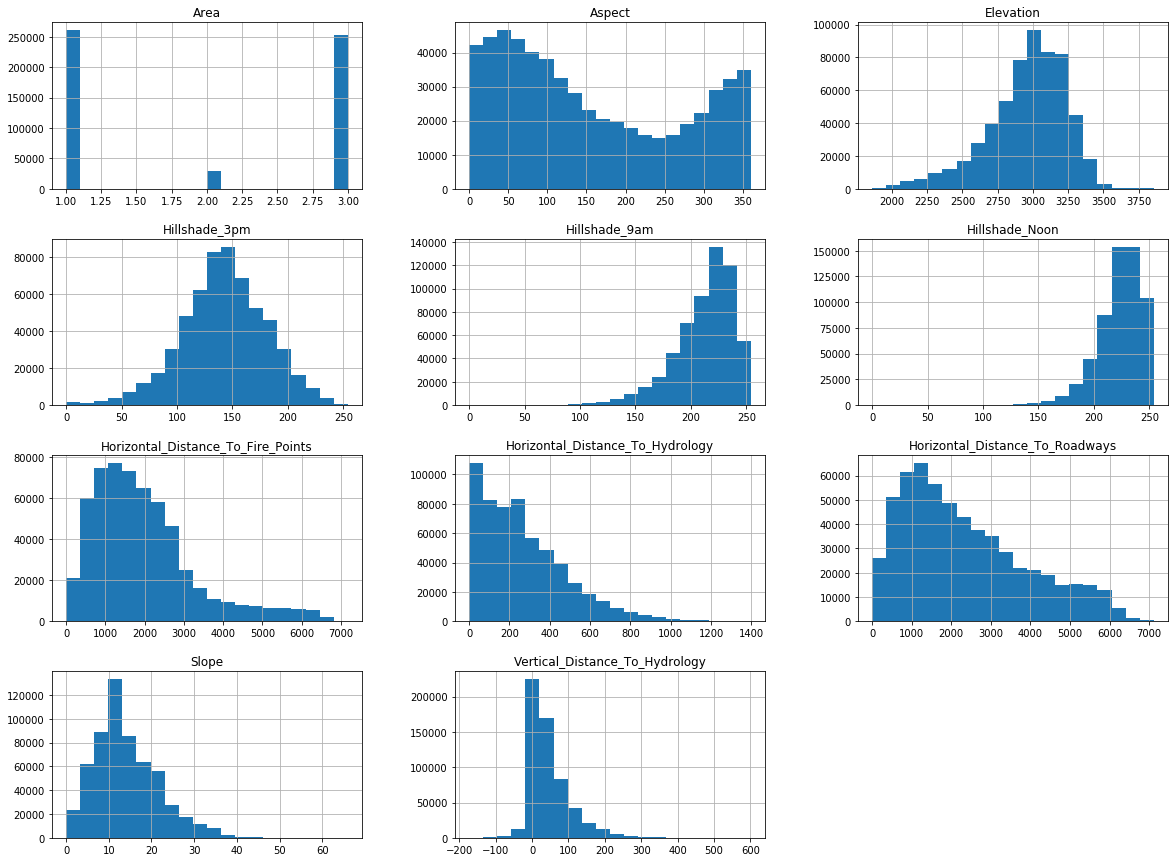

In [7]:
test_viz.hist(bins=20, figsize=(20,15))
plt.show()

We can also look at the cover type distribution within an area.

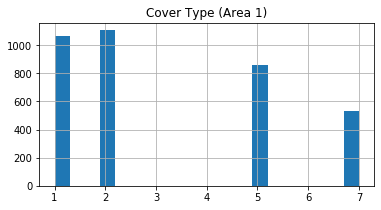

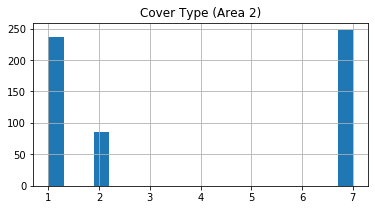

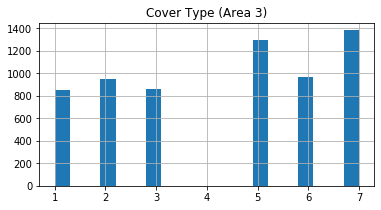

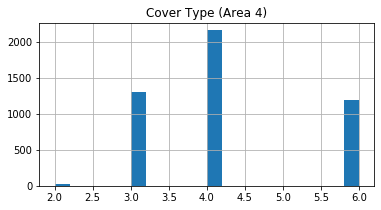

In [42]:
train_viz.loc[train_viz["Area"] == 1, "Cover_Type"].hist(bins=20, figsize=(6,3))
plt.title("Cover Type (Area 1)")
plt.show()

train_viz.loc[train_viz["Area"] == 2, "Cover_Type"].hist(bins=20, figsize=(6,3))
plt.title("Cover Type (Area 2)")
plt.show()

train_viz.loc[train_viz["Area"] == 3, "Cover_Type"].hist(bins=20, figsize=(6,3))
plt.title("Cover Type (Area 3)")
plt.show()

train_viz.loc[train_viz["Area"] == 4, "Cover_Type"].hist(bins=20, figsize=(6,3))
plt.title("Cover Type (Area 4)")
plt.show()

The first striking point is the area. We can see that the test dataset is massively based on areas 1 and 3, and does not contain any area 4.<br/>
We will need to take this into account when designing our models.

We see that cover types are equally distributed in the train dataset. This may not be the case in the test dataset, we will need to build models to infer the distribution and maybe adapt our models to the estimated distribution.

An important point is also to verify that areas have the same behavior both in train and test datasets.

In [9]:
drops_train = ["Area", "Cover_Type", "Hillshade_Noon"]
drops_test = ["Area", "Hillshade_Noon"]

train_viz_1 = train_viz[train_viz["Area"] == 1].drop(drops_train, axis = 1)
train_viz_2 = train_viz[train_viz["Area"] == 2].drop(drops_train, axis = 1)
train_viz_3 = train_viz[train_viz["Area"] == 3].drop(drops_train, axis = 1)
train_viz_4 = train_viz[train_viz["Area"] == 4].drop(drops_train, axis = 1)
test_viz_1 = test_viz[test_viz["Area"] == 1].drop(drops_test, axis = 1)
test_viz_2 = test_viz[test_viz["Area"] == 2].drop(drops_test, axis = 1)
test_viz_3 = test_viz[test_viz["Area"] == 3].drop(drops_test, axis = 1)

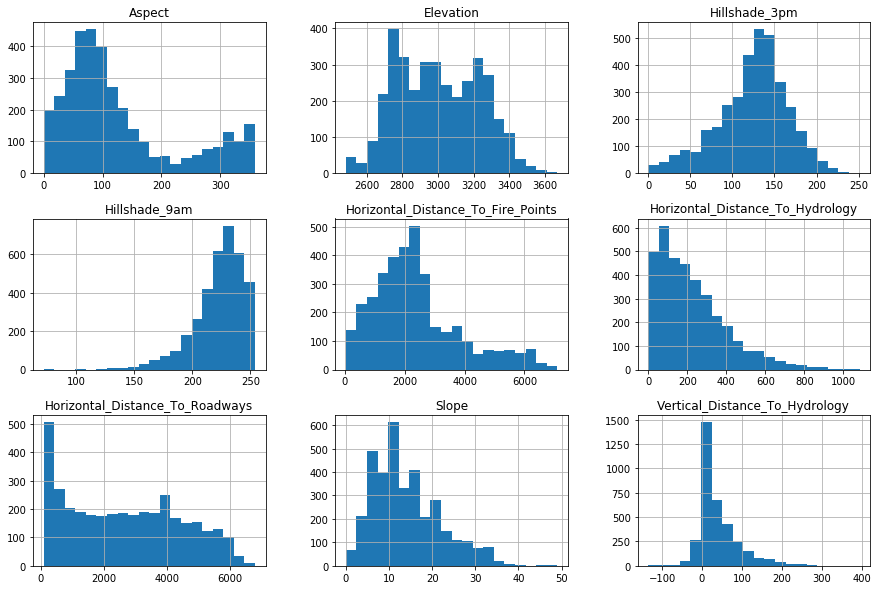

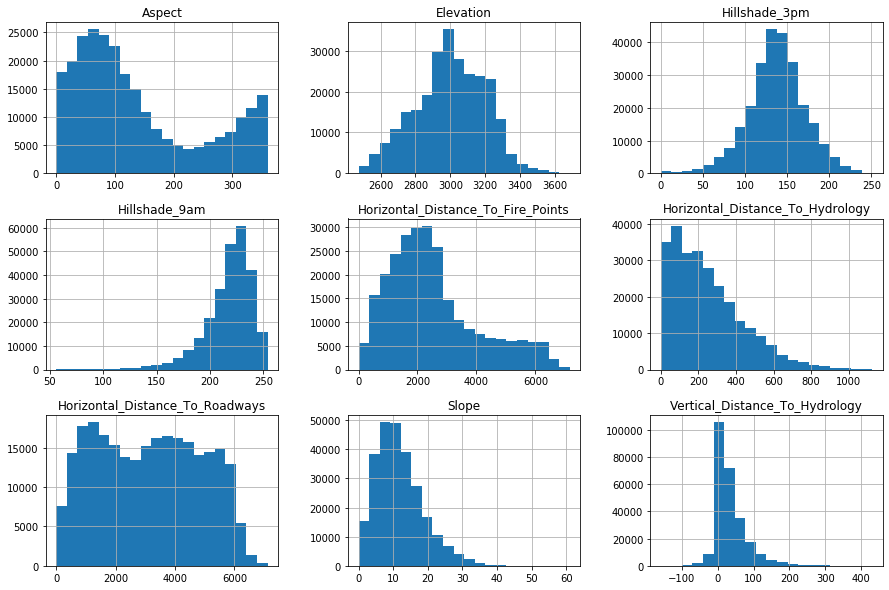

In [10]:
train_viz_1.hist(bins=20, figsize=(15,10))
test_viz_1.hist(bins=20, figsize=(15,10))
plt.show()

We check that for every area, training data is consistent with testing data.

# 2. Feature Engineering

We start by getting rid of the 40 soil types, only considering instead the 7 climatic zones and the 4 geologic zones.

In [11]:
set_cli_2 = ["Soil_Type"+str(i) for i in range(1,6+1)]
set_cli_3 = ["Soil_Type"+str(i) for i in range(7,8+1)]
set_cli_4 = ["Soil_Type"+str(i) for i in range(9,13+1)]
set_cli_5 = ["Soil_Type"+str(i) for i in range(14,15+1)]
set_cli_6 = ["Soil_Type"+str(i) for i in range(16,18+1)]
set_cli_7 = ["Soil_Type"+str(i) for i in range(19,34+1)]
set_cli_8 = ["Soil_Type"+str(i) for i in range(35,40+1)]
sets_cli = [set_cli_2,set_cli_3,set_cli_4,set_cli_5,set_cli_6,set_cli_7,set_cli_8]
nbs_cli = [2,3,4,5,6,7,8]

set_geo_1 = ["Soil_Type"+str(i) for i in [14,15,16,17,19,20,21]]
set_geo_2 = ["Soil_Type"+str(i) for i in [9,22,23]]
set_geo_5 = ["Soil_Type"+str(i) for i in [7,8]]
set_geo_7 = ["Soil_Type"+str(i) for i in [1,2,3,4,5,6,10,11,12,13,18]+list(range(24,40+1))]
sets_geo = [set_geo_1,set_geo_2,set_geo_5,set_geo_7]
nbs_geo = [1,2,5,7]

for i in range(len(nbs_cli)):
    set_cli = sets_cli[i]
    nb_cli = str(nbs_cli[i])
    for soil in set_cli:
        train.loc[train[soil] == 1, "Cli_"+nb_cli] = 1
        test.loc[test[soil] == 1, "Cli_"+nb_cli] = 1

for i in range(len(nbs_geo)):
    set_geo = sets_geo[i]
    nb_geo = str(nbs_geo[i])
    for soil in set_geo:
        train.loc[train[soil] == 1, "Geo_"+nb_geo] = 1
        test.loc[test[soil] == 1, "Geo_"+nb_geo] = 1

train = train.drop(list(train.filter(regex = 'Soil_Type')), axis = 1)
test = test.drop(list(test.filter(regex = 'Soil_Type')), axis = 1)

train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Cli_3,Cli_4,Cli_5,Cli_6,Cli_7,Cli_8,Geo_1,Geo_2,Geo_5,Geo_7
0,242642,2881,130,22,210,54,1020,250,221,88,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,287847,3226,63,14,618,2,1092,232,210,107,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,516307,3298,317,8,661,60,752,198,233,174,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,124860,3080,35,6,175,26,3705,219,227,144,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
def feature_engineering(df):
    df.drop("Id", axis = 1, inplace = True)

    df.insert(1, "Distance_To_Hydrology", np.sqrt(train["Horizontal_Distance_To_Hydrology"]**2 +train["Vertical_Distance_To_Hydrology"]**2))
    df.insert(1, "Distance_max_Fire_To_Hydrology", np.abs(df.loc[:,'Horizontal_Distance_To_Hydrology']+df.loc[:,'Horizontal_Distance_To_Fire_Points']))
    df.insert(1, "Distance_min_Fire_To_Hydrology", np.abs(df.loc[:,'Horizontal_Distance_To_Hydrology']-df.loc[:,'Horizontal_Distance_To_Fire_Points']))
    df.insert(1, "Distance_max_Roadways_To_Hydrology", np.abs(df.loc[:,'Horizontal_Distance_To_Hydrology']+df.loc[:,'Horizontal_Distance_To_Roadways']))
    df.insert(1, "Distance_min_Roadways_To_Hydrology", np.abs(df.loc[:,'Horizontal_Distance_To_Hydrology']-df.loc[:,'Horizontal_Distance_To_Roadways']))
    df.insert(1, "Distance_max_Fire_To_Roadways", np.abs(df.loc[:,'Horizontal_Distance_To_Fire_Points']+df.loc[:,'Horizontal_Distance_To_Roadways']))
    df.insert(1, "Distance_min_Fire_To_Roadways", np.abs(df.loc[:,'Horizontal_Distance_To_Fire_Points']-df.loc[:,'Horizontal_Distance_To_Roadways']))
    df.insert(1, "Mean_Distances", (df.loc[:,'Horizontal_Distance_To_Hydrology']+df.loc[:,'Horizontal_Distance_To_Fire_Points']+df.loc[:,'Horizontal_Distance_To_Roadways'])/3)
    df.insert(1, "Mean_Distances_With_Slope", df.loc[:,'Slope']*(df.loc[:,'Horizontal_Distance_To_Hydrology']+df.loc[:,'Horizontal_Distance_To_Fire_Points']+df.loc[:,'Horizontal_Distance_To_Roadways'])/3)
    df.insert(1, "Hillshade_mean", (df.loc[:,'Hillshade_9am']+df.loc[:,'Hillshade_Noon']+df.loc[:,'Hillshade_3pm'])/3)
    df.insert(1, "Elevation_Hydrology", (df.loc[:,'Elevation']-df.loc[:,'Vertical_Distance_To_Hydrology']))
    return df
train = feature_engineering(df)
test = feature_engineering(df)

In [13]:
train_0 = train.drop("Area", axis = 1)
test_0 = test.drop("Area", axis = 1)

# 3. Simple Model

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 1: 0.8647486772486772


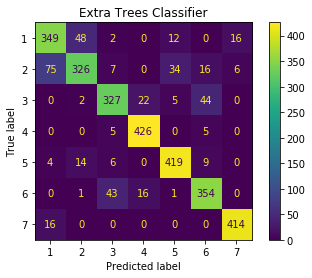

Accuracy 2: 0.8713624338624338


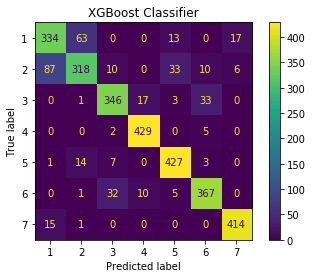

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = train_0.drop("Cover_Type", axis = 1)
y = train_0["Cover_Type"]

X_train, X_eval, y_train, y_eval = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42)

clf_1 = ExtraTreesClassifier(n_estimators=1000,random_state=42)
clf_2 = XGBClassifier(n_estimators=1000,max_depth=8)
clf_1.fit(X_train, y_train)
clf_2.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_eval)
y_pred_2 = clf_2.predict(X_eval)

print("Accuracy 1:", accuracy_score(y_eval,y_pred_1))
ConfusionMatrixDisplay.from_predictions(y_eval, y_pred_1)
plt.title("Extra Trees Classifier")
plt.show()

print("Accuracy 2:", accuracy_score(y_eval,y_pred_2))
ConfusionMatrixDisplay.from_predictions(y_eval, y_pred_2)
plt.title("XGBoost Classifier")
plt.show()

We observe that these simple models have a hard time classifying between types 1 and 2, and between types 3 and 6.<br/>
This gives us the idea to separate classification depending on the cases (with a first classifier and then intraclass classifiers).

# 4. Prediction Pipeline

We implemented our first prediction pipeline in the following way:

- we define our classifier type (that is ExtraTreesClassifier or XGBClassifier)
- with all the training dataset, we train three classifiers
 - the first one is used to classify between classes 1-2, 3-6, 4, 5, 7
 - the second one is used to classify between classes 1, 2
 - the third one is used to classify between classes 3, 6
- this allows to solve the problem of proximity between pairs of classes
- when an input is given, we run it through all classifiers and determine its probability vector
- we take the max of probabilities as answer

We then refined this prediction pipeline by building models conditionally to the area, and then choosing the max probability of a barycenter of probabilities. The $\alpha$ hyperparameter between models can be determined with grid search.

We tried to improve our prediction pipeline by giving more freedom to the classifier. Instead of aggregating probabilities in a 7-tuple and taking the max, we convey all available information to a feed forward neural network that can take the decision for us.

This implies new considerations on training, as we will need to train the neural network on classifiers outputs from unseen data. We choose to split training data in two equal parts and use the first one to train the ensemble classifier and the second one to train the neural network. Then we can actually improve the ensemble classifier by training it on the entire training dataset from scratch.

Finally, once all the pipeline has been wrapped, we can use grid search for the root classifier hyperparameters tuning.

## 4.1 First Pipeline

We start by the first pipeline without area conditioning.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Accuracy: 0.8640873015873016


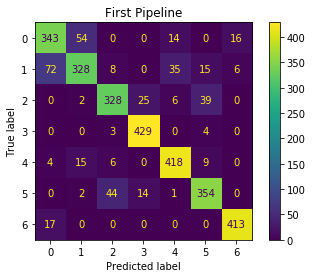

Accuracy: 0.8640873015873016


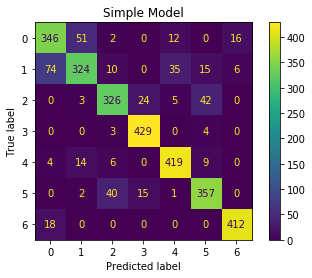

In [41]:
trainset, valset = train_test_split(train_0, test_size=0.2, random_state=42)

train_1 = trainset.copy()
train_1.loc[train_1["Cover_Type"] == 2, "Cover_Type"] = 1
train_1.loc[train_1["Cover_Type"] == 6, "Cover_Type"] = 3
train_2 = trainset[(trainset["Cover_Type"] == 1) | (trainset["Cover_Type"] == 2)]
train_3 = trainset[(trainset["Cover_Type"] == 3) | (trainset["Cover_Type"] == 6)]



X_0 = trainset.drop("Cover_Type", axis = 1).to_numpy()
y_0 = trainset["Cover_Type"].to_numpy()-1

X_1 = train_1.drop("Cover_Type", axis = 1).to_numpy()
y_1 = train_1["Cover_Type"].to_numpy()-1

X_2 = train_2.drop("Cover_Type", axis = 1).to_numpy()
y_2 = train_2["Cover_Type"].to_numpy()-1

X_3 = train_3.drop("Cover_Type", axis = 1).to_numpy()
y_3 = train_3["Cover_Type"].to_numpy()-1

clf_0 = ExtraTreesClassifier(n_estimators=1000, random_state=42)
clf_1 = ExtraTreesClassifier(n_estimators=1000, random_state=42)
clf_2 = ExtraTreesClassifier(n_estimators=1000, random_state=42)
clf_3 = ExtraTreesClassifier(n_estimators=1000, random_state=42)

# clf_0 = XGBClassifier(objective='multi:softprob', n_estimators=500, max_depth=15, learning_rate=0.2)
# clf_1 = XGBClassifier(objective='multi:softprob', n_estimators=500, max_depth=15, learning_rate=0.2)
# clf_2 = XGBClassifier(objective='binary:logistic', n_estimators=1000, max_depth=15, learning_rate=0.1)
# clf_3 = XGBClassifier(objective='binary:logistic', n_estimators=1000, max_depth=15, learning_rate=0.1)

clf_0.fit(X_0, y_0)
clf_1.fit(X_1, y_1)
clf_2.fit(X_2, y_2)
clf_3.fit(X_3, y_3)



X_val = valset.drop("Cover_Type", axis = 1)
y_val = valset["Cover_Type"]-1

y_proba_0 = clf_0.predict_proba(X_val)
y_proba_1 = clf_1.predict_proba(X_val)
y_proba_2 = clf_2.predict_proba(X_val)
y_proba_3 = clf_3.predict_proba(X_val)

y_proba = np.zeros((len(X_val),7))
y_proba[:,0] = y_proba_1[:,0]*y_proba_2[:,0]
y_proba[:,1] = y_proba_1[:,0]*y_proba_2[:,1]
y_proba[:,2] = y_proba_1[:,1]*y_proba_3[:,0]
y_proba[:,3] = y_proba_1[:,2]
y_proba[:,4] = y_proba_1[:,3]
y_proba[:,5] = y_proba_1[:,1]*y_proba_3[:,1]
y_proba[:,6] = y_proba_1[:,4]

y_pred_0 = np.argmax(y_proba_0, axis=1)
y_pred = np.argmax(y_proba, axis=1)



print("Accuracy:", accuracy_score(y_val,y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("First Pipeline")
plt.show()

print("Accuracy:", accuracy_score(y_val,y_pred_0))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_0)
plt.title("Simple Model")
plt.show()

We can see that XGBClassifier performs better than ExtraTreesClassifier.<br/>
Moreover, we observe that our strategy of multiple classes gives better results than the simple model.

## 4.2 Second Pipeline

We now add similar classifiers conditionnally to the area.

In [44]:
trainset, valset = train_test_split(train, test_size=0.2, random_state=42)

train_A0 = trainset.drop("Area", axis = 1)
train_A1 = trainset[trainset["Area"] == 1].drop(["Area"]+list(trainset.filter(regex = 'Wilderness_Area')), axis = 1)
train_A2 = trainset[trainset["Area"] == 2].drop(["Area"]+list(trainset.filter(regex = 'Wilderness_Area')), axis = 1)
train_A3 = trainset[trainset["Area"] == 3].drop(["Area"]+list(trainset.filter(regex = 'Wilderness_Area')), axis = 1)

In [17]:
# Area 0 (global)

# class_weight={0:0.37,1:0.49,2:0.06,3:0.01,4:0.02,5:0.03,6:0.04}

train_A0_1 = train_A0.copy()
train_A0_1.loc[train_A0_1["Cover_Type"] == 2, "Cover_Type"] = 1
train_A0_1.loc[train_A0_1["Cover_Type"] == 6, "Cover_Type"] = 3
train_A0_2 = train_A0[(train_A0["Cover_Type"] == 1) | (train_A0["Cover_Type"] == 2)]
train_A0_3 = train_A0[(train_A0["Cover_Type"] == 3) | (train_A0["Cover_Type"] == 6)]

X_A0_1 = train_A0_1.drop("Cover_Type", axis = 1).to_numpy()
y_A0_1 = train_A0_1["Cover_Type"].to_numpy()-1

X_A0_2 = train_A0_2.drop("Cover_Type", axis = 1).to_numpy()
y_A0_2 = train_A0_2["Cover_Type"].to_numpy()-1

X_A0_3 = train_A0_3.drop("Cover_Type", axis = 1).to_numpy()
y_A0_3 = train_A0_3["Cover_Type"].to_numpy()-1

clf_A0_1 = ExtraTreesClassifier(n_estimators=700, random_state=42)
clf_A0_2 = ExtraTreesClassifier(n_estimators=500, random_state=42)
clf_A0_3 = ExtraTreesClassifier(n_estimators=500, random_state=42)

clf_A0_1.fit(X_A0_1, y_A0_1)
clf_A0_2.fit(X_A0_2, y_A0_2)
clf_A0_3.fit(X_A0_3, y_A0_3)

# Area 1

train_A1_1 = train_A1.copy()
train_A1_1.loc[train_A1_1["Cover_Type"] == 2, "Cover_Type"] = 1
train_A1_2 = train_A1[(train_A1["Cover_Type"] == 1) | (train_A1["Cover_Type"] == 2)]

X_A1_1 = train_A1_1.drop("Cover_Type", axis = 1).to_numpy()
y_A1_1 = train_A1_1["Cover_Type"].to_numpy()-1

X_A1_2 = train_A1_2.drop("Cover_Type", axis = 1).to_numpy()
y_A1_2 = train_A1_2["Cover_Type"].to_numpy()-1

clf_A1_1 = ExtraTreesClassifier(n_estimators=700, random_state=42)
clf_A1_2 = ExtraTreesClassifier(n_estimators=500, random_state=42)

clf_A1_1.fit(X_A1_1, y_A1_1)
clf_A1_2.fit(X_A1_2, y_A1_2)

# Area 2

train_A2_1 = train_A2.copy()

X_A2_1 = train_A2_1.drop("Cover_Type", axis = 1).to_numpy()
y_A2_1 = train_A2_1["Cover_Type"].to_numpy()-1

clf_A2_1 = ExtraTreesClassifier(n_estimators=700, random_state=42)

clf_A2_1.fit(X_A2_1, y_A2_1)
    
# Area 3

train_A3_1 = train_A3.copy()
train_A3_1.loc[train_A3_1["Cover_Type"] == 2, "Cover_Type"] = 1
train_A3_1.loc[train_A3_1["Cover_Type"] == 6, "Cover_Type"] = 3
train_A3_2 = train_A3[(train_A3["Cover_Type"] == 1) | (train_A3["Cover_Type"] == 2)]
train_A3_3 = train_A3[(train_A3["Cover_Type"] == 3) | (train_A3["Cover_Type"] == 6)]

X_A3_1 = train_A3_1.drop("Cover_Type", axis = 1).to_numpy()
y_A3_1 = train_A3_1["Cover_Type"].to_numpy()-1

X_A3_2 = train_A3_2.drop("Cover_Type", axis = 1).to_numpy()
y_A3_2 = train_A3_2["Cover_Type"].to_numpy()-1

X_A3_3 = train_A3_3.drop("Cover_Type", axis = 1).to_numpy()
y_A3_3 = train_A3_3["Cover_Type"].to_numpy()-1

clf_A3_1 = ExtraTreesClassifier(n_estimators=700, random_state=42)
clf_A3_2 = ExtraTreesClassifier(n_estimators=500, random_state=42)
clf_A3_3 = ExtraTreesClassifier(n_estimators=500, random_state=42)

clf_A3_1.fit(X_A3_1, y_A3_1)
clf_A3_2.fit(X_A3_2, y_A3_2)
clf_A3_3.fit(X_A3_3, y_A3_3)

ExtraTreesClassifier(n_estimators=500, random_state=42)

Now we just need to define how we predict the cover type for a given input.

In [45]:
alpha_1, alpha_2, alpha_3 = 0.2, 0.3, 0.5

valset_areas = valset.copy()
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A0"] = 1 - alpha_1
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A1"] = alpha_1
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A3"] = 0
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A0"] = 1 - alpha_2
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A2"] = alpha_2
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A3"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A0"] = 1 - alpha_3
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A3"] = alpha_3
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A0"] = 1
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A3"] = 0

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning:

Accuracy: 0.8650793650793651


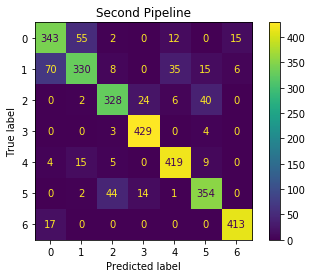

In [46]:
X_A0_val = valset.drop(["Area", "Cover_Type"], axis = 1)
X_A123_val = valset.drop(["Area", "Cover_Type"]+list(valset.filter(regex = 'Wilderness_Area')), axis = 1)
y_val = valset["Cover_Type"]-1

# Area 0

y_A0_proba_1 = clf_A0_1.predict_proba(X_A0_val)
y_A0_proba_2 = clf_A0_2.predict_proba(X_A0_val)
y_A0_proba_3 = clf_A0_3.predict_proba(X_A0_val)

y_A0_proba = np.zeros((len(X_A0_val),7))
y_A0_proba[:,0] = y_A0_proba_1[:,0]*y_A0_proba_2[:,0]
y_A0_proba[:,1] = y_A0_proba_1[:,0]*y_A0_proba_2[:,1]
y_A0_proba[:,2] = y_A0_proba_1[:,1]*y_A0_proba_3[:,0]
y_A0_proba[:,3] = y_A0_proba_1[:,2]
y_A0_proba[:,4] = y_A0_proba_1[:,3]
y_A0_proba[:,5] = y_A0_proba_1[:,1]*y_A0_proba_3[:,1]
y_A0_proba[:,6] = y_A0_proba_1[:,4]

# Area 1

y_A1_proba_1 = clf_A1_1.predict_proba(X_A123_val)
y_A1_proba_2 = clf_A1_2.predict_proba(X_A123_val)

y_A1_proba = np.zeros((len(X_A123_val),7))
y_A1_proba[:,0] = y_A1_proba_1[:,0]*y_A1_proba_2[:,0]
y_A1_proba[:,1] = y_A1_proba_1[:,0]*y_A1_proba_2[:,1]
y_A1_proba[:,2] = 0
y_A1_proba[:,3] = 0
y_A1_proba[:,4] = y_A1_proba_1[:,1]
y_A1_proba[:,5] = 0
y_A1_proba[:,6] = y_A1_proba_1[:,2]

# Area 2

y_A2_proba_1 = clf_A2_1.predict_proba(X_A123_val)

y_A2_proba = np.zeros((len(X_A123_val),7))
y_A2_proba[:,0] = y_A2_proba_1[:,0]
y_A2_proba[:,1] = y_A2_proba_1[:,1]
y_A2_proba[:,2] = 0
y_A2_proba[:,3] = 0
y_A2_proba[:,4] = 0
y_A2_proba[:,5] = 0
y_A2_proba[:,6] = y_A2_proba_1[:,2]

# Area 3

y_A3_proba_1 = clf_A3_1.predict_proba(X_A123_val)
y_A3_proba_2 = clf_A3_2.predict_proba(X_A123_val)
y_A3_proba_3 = clf_A3_3.predict_proba(X_A123_val)

y_A3_proba = np.zeros((len(X_A123_val),7))
y_A3_proba[:,0] = y_A3_proba_1[:,0]*y_A3_proba_2[:,0]
y_A3_proba[:,1] = y_A3_proba_1[:,0]*y_A3_proba_2[:,1]
y_A3_proba[:,2] = y_A3_proba_1[:,1]*y_A3_proba_3[:,0]
y_A3_proba[:,3] = 0
y_A3_proba[:,4] = y_A3_proba_1[:,2]
y_A3_proba[:,5] = y_A3_proba_1[:,1]*y_A3_proba_3[:,1]
y_A3_proba[:,6] = y_A3_proba_1[:,3]



# Combination

coeffs_0 = np.expand_dims(valset_areas.loc[:,"Coeff_A0"].to_numpy(), axis=1)
coeffs_1 = np.expand_dims(valset_areas.loc[:,"Coeff_A1"].to_numpy(), axis=1)
coeffs_2 = np.expand_dims(valset_areas.loc[:,"Coeff_A2"].to_numpy(), axis=1)
coeffs_3 = np.expand_dims(valset_areas.loc[:,"Coeff_A3"].to_numpy(), axis=1)

y_proba = coeffs_0*y_A0_proba + coeffs_1*y_A1_proba +coeffs_2*y_A2_proba + coeffs_3*y_A3_proba
y_pred = np.argmax(y_proba, axis=1)

print("Accuracy:", accuracy_score(y_val,y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("Second Pipeline")
plt.show()

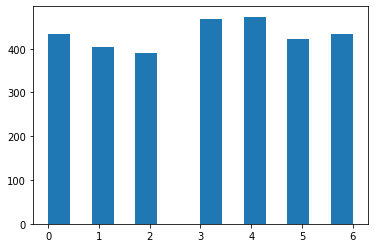

In [20]:
plt.hist(y_pred,bins=14)
plt.show()

In [21]:
test = pd.read_csv("kaggle/input/map553-2021/test-kag.csv")

test.loc[test["Wilderness_Area1"] == 1, "Area"] = 1
test.loc[test["Wilderness_Area2"] == 1, "Area"] = 2
test.loc[test["Wilderness_Area3"] == 1, "Area"] = 3

set_cli_2 = ["Soil_Type"+str(i) for i in range(1,6+1)]
set_cli_3 = ["Soil_Type"+str(i) for i in range(7,8+1)]
set_cli_4 = ["Soil_Type"+str(i) for i in range(9,13+1)]
set_cli_5 = ["Soil_Type"+str(i) for i in range(14,15+1)]
set_cli_6 = ["Soil_Type"+str(i) for i in range(16,18+1)]
set_cli_7 = ["Soil_Type"+str(i) for i in range(19,34+1)]
set_cli_8 = ["Soil_Type"+str(i) for i in range(35,40+1)]
sets_cli = [set_cli_2,set_cli_3,set_cli_4,set_cli_5,set_cli_6,set_cli_7,set_cli_8]
nbs_cli = [2,3,4,5,6,7,8]

set_geo_1 = ["Soil_Type"+str(i) for i in [14,15,16,17,19,20,21]]
set_geo_2 = ["Soil_Type"+str(i) for i in [9,22,23]]
set_geo_5 = ["Soil_Type"+str(i) for i in [7,8]]
set_geo_7 = ["Soil_Type"+str(i) for i in [1,2,3,4,5,6,10,11,12,13,18]+list(range(24,40+1))]
sets_geo = [set_geo_1,set_geo_2,set_geo_5,set_geo_7]
nbs_geo = [1,2,5,7]

for i in range(len(nbs_cli)):
    set_cli = sets_cli[i]
    nb_cli = str(nbs_cli[i])
    for soil in set_cli:
        test.loc[test[soil] == 1, "Cli_"+nb_cli] = 1

for i in range(len(nbs_geo)):
    set_geo = sets_geo[i]
    nb_geo = str(nbs_geo[i])
    for soil in set_geo:
        test.loc[test[soil] == 1, "Geo_"+nb_geo] = 1

test = test.drop(list(test.filter(regex = 'Soil_Type')), axis = 1)
test.fillna(0, inplace = True)

test.insert(2, "Distance_To_Hydrology", np.sqrt(test["Horizontal_Distance_To_Hydrology"]**2 +test["Vertical_Distance_To_Hydrology"]**2))

In [22]:
alpha_1, alpha_2, alpha_3 = 0.2, 0.3, 0.5

valset_areas = test.copy()
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A0"] = 1 - alpha_1
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A1"] = alpha_1
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 1, "Coeff_A3"] = 0
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A0"] = 1 - alpha_2
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A2"] = alpha_2
valset_areas.loc[valset_areas["Area"] == 2, "Coeff_A3"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A0"] = 1 - alpha_3
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 3, "Coeff_A3"] = alpha_3
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A0"] = 1
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A1"] = 0
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A2"] = 0
valset_areas.loc[valset_areas["Area"] == 4, "Coeff_A3"] = 0

In [30]:
X_A0_test = test.drop(["Id", "Area"], axis = 1)
X_A123_test = test.drop(["Id", "Area"]+list(valset.filter(regex = 'Wilderness_Area')), axis = 1)

# Area 0

y_A0_proba_1 = clf_A0_1.predict_proba(X_A0_test)
y_A0_proba_2 = clf_A0_2.predict_proba(X_A0_test)
y_A0_proba_3 = clf_A0_3.predict_proba(X_A0_test)

y_A0_proba = np.zeros((len(X_A0_test),7))
y_A0_proba[:,0] = y_A0_proba_1[:,0]*y_A0_proba_2[:,0]
y_A0_proba[:,1] = y_A0_proba_1[:,0]*y_A0_proba_2[:,1]
y_A0_proba[:,2] = y_A0_proba_1[:,1]*y_A0_proba_3[:,0]
y_A0_proba[:,3] = y_A0_proba_1[:,2]
y_A0_proba[:,4] = y_A0_proba_1[:,3]
y_A0_proba[:,5] = y_A0_proba_1[:,1]*y_A0_proba_3[:,1]
y_A0_proba[:,6] = y_A0_proba_1[:,4]

# Area 1

y_A1_proba_1 = clf_A1_1.predict_proba(X_A123_test)
y_A1_proba_2 = clf_A1_2.predict_proba(X_A123_test)

y_A1_proba = np.zeros((len(X_A123_test),7))
y_A1_proba[:,0] = y_A1_proba_1[:,0]*y_A1_proba_2[:,0]
y_A1_proba[:,1] = y_A1_proba_1[:,0]*y_A1_proba_2[:,1]
y_A1_proba[:,2] = 0
y_A1_proba[:,3] = 0
y_A1_proba[:,4] = y_A1_proba_1[:,1]
y_A1_proba[:,5] = 0
y_A1_proba[:,6] = y_A1_proba_1[:,2]

# Area 2

y_A2_proba_1 = clf_A2_1.predict_proba(X_A123_test)

y_A2_proba = np.zeros((len(X_A123_test),7))
y_A2_proba[:,0] = y_A2_proba_1[:,0]
y_A2_proba[:,1] = y_A2_proba_1[:,1]
y_A2_proba[:,2] = 0
y_A2_proba[:,3] = 0
y_A2_proba[:,4] = 0
y_A2_proba[:,5] = 0
y_A2_proba[:,6] = y_A2_proba_1[:,2]

# Area 3

y_A3_proba_1 = clf_A3_1.predict_proba(X_A123_test)
y_A3_proba_2 = clf_A3_2.predict_proba(X_A123_test)
y_A3_proba_3 = clf_A3_3.predict_proba(X_A123_test)

y_A3_proba = np.zeros((len(X_A123_test),7))
y_A3_proba[:,0] = y_A3_proba_1[:,0]*y_A3_proba_2[:,0]
y_A3_proba[:,1] = y_A3_proba_1[:,0]*y_A3_proba_2[:,1]
y_A3_proba[:,2] = y_A3_proba_1[:,1]*y_A3_proba_3[:,0]
y_A3_proba[:,3] = 0
y_A3_proba[:,4] = y_A3_proba_1[:,2]
y_A3_proba[:,5] = y_A3_proba_1[:,1]*y_A3_proba_3[:,1]
y_A3_proba[:,6] = y_A3_proba_1[:,3]



# Combination

coeffs_0 = np.expand_dims(valset_areas.loc[:,"Coeff_A0"].to_numpy(), axis=1)
coeffs_1 = np.expand_dims(valset_areas.loc[:,"Coeff_A1"].to_numpy(), axis=1)
coeffs_2 = np.expand_dims(valset_areas.loc[:,"Coeff_A2"].to_numpy(), axis=1)
coeffs_3 = np.expand_dims(valset_areas.loc[:,"Coeff_A3"].to_numpy(), axis=1)

y_proba = coeffs_0*y_A0_proba + coeffs_1*y_A1_proba +coeffs_2*y_A2_proba + coeffs_3*y_A3_proba
y_pred = np.argmax(y_proba, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning:

In [31]:
y_pred = y_pred+1

In [32]:
testt = test.copy()
testt["Cover_Type"] = pd.Series(y_pred)
testt.loc[:,["Id","Cover_Type"]].to_csv('submission-kag.csv', index=False)

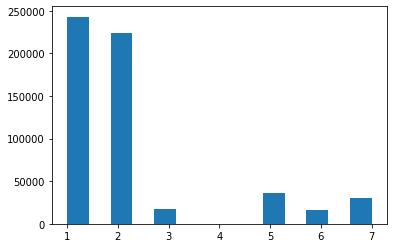

In [33]:
plt.hist(y_pred, bins=14)
plt.show()

In [34]:
print("1: ", len(y_pred[y_pred==1])/len(y_pred))
print("2: ", len(y_pred[y_pred==2])/len(y_pred))
print("3: ", len(y_pred[y_pred==3])/len(y_pred))
print("4: ", len(y_pred[y_pred==4])/len(y_pred))
print("5: ", len(y_pred[y_pred==5])/len(y_pred))
print("6: ", len(y_pred[y_pred==6])/len(y_pred))
print("7: ", len(y_pred[y_pred==6])/len(y_pred))

1:  0.4295430930283517
2:  0.3960755762583673
3:  0.029791903755486914
4:  0.0
5:  0.06390265280300834
6:  0.027653686569168674
7:  0.027653686569168674


In [36]:
y_pred_1 = np.argmax(y_A1_proba, axis=1)+1

print("1: ", len(y_pred_1[y_pred_1==1])/len(y_pred_1))
print("2: ", len(y_pred_1[y_pred_1==2])/len(y_pred_1))
print("3: ", len(y_pred_1[y_pred_1==3])/len(y_pred_1))
print("4: ", len(y_pred_1[y_pred_1==4])/len(y_pred_1))
print("5: ", len(y_pred_1[y_pred_1==5])/len(y_pred_1))
print("6: ", len(y_pred_1[y_pred_1==6])/len(y_pred_1))
print("7: ", len(y_pred_1[y_pred_1==6])/len(y_pred_1))

1:  0.40032550380638
2:  0.5190513384179314
3:  0.0
4:  0.0
5:  0.044425438069454946
6:  0.0
7:  0.0


In [38]:
y_pred_3 = np.argmax(y_A3_proba, axis=1)+1

print("1: ", len(y_pred_3[y_pred_3==1])/len(y_pred_3))
print("2: ", len(y_pred_3[y_pred_3==2])/len(y_pred_3))
print("3: ", len(y_pred_3[y_pred_3==3])/len(y_pred_3))
print("4: ", len(y_pred_3[y_pred_3==4])/len(y_pred_3))
print("5: ", len(y_pred_3[y_pred_3==5])/len(y_pred_3))
print("6: ", len(y_pred_3[y_pred_3==6])/len(y_pred_3))
print("7: ", len(y_pred_3[y_pred_3==6])/len(y_pred_3))

1:  0.40464258197677294
2:  0.3039519908392414
3:  0.06000261534002955
4:  0.0
5:  0.07581128554565182
6:  0.06877637429050067
7:  0.06877637429050067


# Final Classification Model

To improve our results further, we used a meta-model to deal with all predictions and predict the cover type. To do so, we chose the neural network since it was the one which generalized better.
 
We first train the previous classifiers on 50% of the data, then make them predict the cover type of the 50% Training data left and finally train the model on these 50%.

We then train the previous classifiers on the rest of the training data and the model is ready for inference

This method allowed to improve our accuracy to 84.8% on the 1st part of the test data.


In [ ]:
pred = np.concatenate([y_A0_proba, y_A1_proba, y_A2_proba, y_A3_proba])

In [ ]:
pred_val = np.concatenate([y_A0_proba, y_A1_proba, y_A2_proba, y_A3_proba])

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(32, activation='relu',kernel_initializer="he_uniform", input_shape=(pred.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

opt= tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

In [ ]:
y_eval_cat = to_categorical(y_eval, num_classes = 7)
history = model.fit(pred, y_eval_cat, validation_data=(pred_val, y_val), epochs=20, batch_size=64)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(pred_val), axis=1)
print("Accuracy:", accuracy_score(y_val,y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("Final Model")
plt.show()

In [ ]:
pred = np.concatenate([y_A0_proba, y_A1_proba, y_A2_proba, y_A3_proba])
pred = model.predict(pred)
pred = np.argmax(pred, axis=1) +1

In [ ]:
test['Cover_Type'] = pd.Series(pred)
test.loc[:,["Id","Cover_Type"]].to_csv('submission.csv', index=False)

In [ ]:
for k in range(1,8):
    print(len(pred[pred==k]))